In [1]:
import pandas as pd
import numpy as np
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet import *
from NN_library.ConvNet.ConvNet import *
from NN_library.ConvNet.train_ConvNet import *
%load_ext autoreload
%autoreload 2

Using device: cuda
Using device: cuda


In [2]:
unet = AutoUNet()
convnet = ConvNet(16)

args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : 'NN_library/ConvNet/Conv_w_AutoUnet'}
convnet = load_network(convnet, 'NN_library/ConvNet/Conv_w_AutoUnet_0', args)
unet = load_network(unet, 'NN_library/AutoUnet/AutoUnet_w_Conv_0', args)  

unet.to(args['dev'])
convnet.to(args['dev'])

ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (13): ReLU()
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=2, bias=True)
    (2): Sigmoid()
  )
)

In [3]:
data = dataset_big()
loader = DataLoader(data, batch_size = 32, shuffle=False, num_workers=0)

In [4]:
damage = []
shrinkage = []
stiffness = []

In [5]:
for i, (geometry, imp_shrinkage) in enumerate(loader):
    geometry = geometry.to(args['dev'])
    imp_shrinkage = imp_shrinkage.to(args['dev'])
    for n in range(10):
        if n == 0:
            x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], imp_shrinkage[:,[n],:,:]], axis=1)
        else:
            x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y.detach()], axis=1)
        y = unet(x)
    x_shr = torch.cat([geometry, imp_shrinkage[:,[n+1],:,:], y], axis=1)
    y_shr = convnet(x_shr)
    damage += (y.sum(axis=(1,2,3)) / 99**2).tolist()
    stiffness += y_shr[:,0].tolist()
    shrinkage += y_shr[:,1].tolist()

In [6]:
torch.cuda.empty_cache()

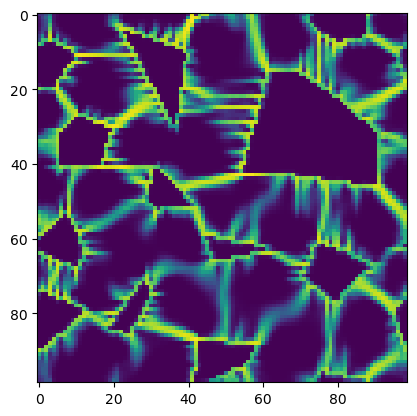

In [7]:
plt.imshow(y.detach().cpu()[0,0])

In [8]:
df = pd.read_pickle('microstucture_big.pkl')
df.head()

,curve_n,curve_area,sizes,ratios,roundness
0,"[1, 13, 0]","[105.80074636770647, 227.96328911964014, 0.0]","{16: [[12.156105356917523, 10.623884723487098]...","{16: [1.1442241395977328], 8: [1.4751999563701...","{16: [0.79153385961529], 8: [0.605976146544928..."
1,"[4, 0, 0]","[278.0806039902927, 0.0, 0.0]","{16: [[13.2100775605406, 8.901632629103986], [...","{16: [1.4840061493158128, 1.1343764452308507, ...","{16: [0.7175189460203348, 0.8022948062440893, ..."
2,"[4, 0, 0]","[313.421728531106, 0.0, 0.0]","{16: [[14.478128114885118, 7.07690334800868], ...","{16: [2.045828154338015, 1.7307378409831589, 1...","{16: [0.7837420397213821, 0.7111899015206651, ..."
3,"[3, 10, 0]","[218.03944019512616, 173.47923426585353, 0.0]","{16: [[10.690182333262214, 9.950449294945646],...","{16: [1.0743416720581973, 1.5227016310172952, ...","{16: [0.8521819843178768, 0.7467008904049787, ..."
4,"[4, 5, 0]","[299.7357110559889, 69.95675483906378, 0.0]","{16: [[11.825311336277718, 7.229526295980998],...","{16: [1.6356965660186595, 2.5639894808309918, ...","{16: [0.7855563249650631, 0.4722256149583713, ..."


In [9]:
df['damage'] = damage
df['shrinkage'] = shrinkage
df['stiffness_ratio'] = stiffness
df['shrinkage'] = df['shrinkage'] * imp_shrinkage[0,-1,0,0].item()

In [10]:
X = np.array([area for area in df['curve_area']])

In [11]:
df['aggregate_ratio'] = X.sum(axis=1) / (32*32)

In [12]:
df['curve_16'] = (X / X.sum(axis=1).reshape(-1,1))[:,0]
df['curve_8'] = (X / X.sum(axis=1).reshape(-1,1))[:,1]
df['curve_4'] = (X / X.sum(axis=1).reshape(-1,1))[:,2]

In [13]:
df.head()

,curve_n,curve_area,sizes,ratios,roundness,damage,shrinkage,stiffness_ratio,aggregate_ratio,curve_16,curve_8,curve_4
0,"[1, 13, 0]","[105.80074636770647, 227.96328911964014, 0.0]","{16: [[12.156105356917523, 10.623884723487098]...","{16: [1.1442241395977328], 8: [1.4751999563701...","{16: [0.79153385961529], 8: [0.605976146544928...",0.192238,-0.000665,0.466355,0.325941,0.316993,0.683007,0.0
1,"[4, 0, 0]","[278.0806039902927, 0.0, 0.0]","{16: [[13.2100775605406, 8.901632629103986], [...","{16: [1.4840061493158128, 1.1343764452308507, ...","{16: [0.7175189460203348, 0.8022948062440893, ...",0.175496,-0.000688,0.501612,0.271563,1.000000,0.000000,0.0
2,"[4, 0, 0]","[313.421728531106, 0.0, 0.0]","{16: [[14.478128114885118, 7.07690334800868], ...","{16: [2.045828154338015, 1.7307378409831589, 1...","{16: [0.7837420397213821, 0.7111899015206651, ...",0.170600,-0.000634,0.480870,0.306076,1.000000,0.000000,0.0
3,"[3, 10, 0]","[218.03944019512616, 173.47923426585353, 0.0]","{16: [[10.690182333262214, 9.950449294945646],...","{16: [1.0743416720581973, 1.5227016310172952, ...","{16: [0.8521819843178768, 0.7467008904049787, ...",0.210610,-0.000601,0.446522,0.382342,0.556907,0.443093,0.0
4,"[4, 5, 0]","[299.7357110559889, 69.95675483906378, 0.0]","{16: [[11.825311336277718, 7.229526295980998],...","{16: [1.6356965660186595, 2.5639894808309918, ...","{16: [0.7855563249650631, 0.4722256149583713, ...",0.191100,-0.000615,0.445978,0.361028,0.810770,0.189230,0.0


In [14]:
df['mortar_damage'] = np.array([df['damage'][i]*32*32/(32*32-sum(df['curve_area'][i])) for i in range(100000)])

In [15]:
df.head()

,curve_n,curve_area,sizes,ratios,roundness,damage,shrinkage,stiffness_ratio,aggregate_ratio,curve_16,curve_8,curve_4,mortar_damage
0,"[1, 13, 0]","[105.80074636770647, 227.96328911964014, 0.0]","{16: [[12.156105356917523, 10.623884723487098]...","{16: [1.1442241395977328], 8: [1.4751999563701...","{16: [0.79153385961529], 8: [0.605976146544928...",0.192238,-0.000665,0.466355,0.325941,0.316993,0.683007,0.0,0.285195
1,"[4, 0, 0]","[278.0806039902927, 0.0, 0.0]","{16: [[13.2100775605406, 8.901632629103986], [...","{16: [1.4840061493158128, 1.1343764452308507, ...","{16: [0.7175189460203348, 0.8022948062440893, ...",0.175496,-0.000688,0.501612,0.271563,1.000000,0.000000,0.0,0.240921
2,"[4, 0, 0]","[313.421728531106, 0.0, 0.0]","{16: [[14.478128114885118, 7.07690334800868], ...","{16: [2.045828154338015, 1.7307378409831589, 1...","{16: [0.7837420397213821, 0.7111899015206651, ...",0.170600,-0.000634,0.480870,0.306076,1.000000,0.000000,0.0,0.245848
3,"[3, 10, 0]","[218.03944019512616, 173.47923426585353, 0.0]","{16: [[10.690182333262214, 9.950449294945646],...","{16: [1.0743416720581973, 1.5227016310172952, ...","{16: [0.8521819843178768, 0.7467008904049787, ...",0.210610,-0.000601,0.446522,0.382342,0.556907,0.443093,0.0,0.340982
4,"[4, 5, 0]","[299.7357110559889, 69.95675483906378, 0.0]","{16: [[11.825311336277718, 7.229526295980998],...","{16: [1.6356965660186595, 2.5639894808309918, ...","{16: [0.7855563249650631, 0.4722256149583713, ...",0.191100,-0.000615,0.445978,0.361028,0.810770,0.189230,0.0,0.299074


In [16]:
df.to_pickle('microstucture_big.pkl')